# PyTorch Used Cars Dataset Example


## 1. Introduction

This tutorial focuses on how to train a federated regression model on Non-IID dataset using PyTorch framework. We will be working on the Used Cars dataset to perform federated learning. The sections of this tutorial are presented as follows;

- Dataset Preparation;
- Node Configurations;
- Create an Experiment to Train a Model;
- Testing Federated Model.

## 2. Dataset Preparation

In this tutorial, we will be using the Used Cars dataset. The goal of the model will be to predict the price of the car based on given features. 

You can download the dataset from [here](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes). To be able to download this dataset you need to have a Kaggle account. After downloading, you can create folders for the dataset in the Fed-BioMed `Researcher` `fbm-researcher/notebooks/data` directory.

```shell
cd /path/to/fedbiomed/components/directory
fedbiomed component create -c researcher
mkdir fbm-researcher/notebooks/data/UsedCars && mkdir fbm-researcher/notebooks/data/UsedCars/raw 
```

You can extract CSV files in the zip file into `fbm-researcher/notebooks/data/UsedCars/raw`. Your file tree should be like the tree below;

```shell
├── data
│   └── UsedCars
│       └── raw
│           ├── audi.csv
│           ├── bmw.csv
│           ├── cclass.csv
│           ├── focus.csv
│           ├── ford.csv
│           ├── hyundi.csv
│           ├── merc.csv
│           ├── skoda.csv
│           ├── toyota.csv
│           ├── unclean cclass.csv
│           ├── unclean focus.csv
│           ├── vauxhall.csv
│           └── vw.csv

```

### 2.1 Selecting CSV Dataset for Each Node

Each CSV dataset contains features for different car brands. It is a good example for applying federated learning through each dataset if we assume that these datasets will be stored in different locations. We will be working on 3 datasets that are `audi.csv`, `bmw.csv`, and `ford.csv`. We will deploy `audi.csv` and `bmw.csv` on different nodes and use `ford.csv` for final testing at the central researcher using the model trained on two nodes.   

### 2.2 Preprocessing 

Before deploying datasets we need to apply some preprocessing to make them ready for the federated training. Since car `model` and `fuelType` features are not consistent across the dataset, we can drop them. We also need to apply label encoding for the `transmission` feature.

**Note:** Dropping and encoding columns can be also done in the `training_data` method of `TrainingPlan` but it is always better to deploy clean/prepared datasets in the nodes. 
 

Let's starting with loading CSV datasets using `pd.read_csv` API. Please make sure that you have launched your Jupyter notebook using the command `fedbiomed researcher start` so you can follow code examples without changing file paths.  


In [ ]:
import os
import pandas as pd
from fedbiomed.researcher.config import config
# Optional: to be able use different researcher configuration.
# config.load(root=<different-component-root>) 


root_dir = config.root

audi = pd.read_csv(os.path.join(root_dir,'notebooks','data','UsedCars', 'raw', 'audi.csv'))
bmw = pd.read_csv(os.path.join(root_dir,'notebooks', 'data', 'UsedCars', 'raw', 'bmw.csv'))
ford = pd.read_csv(os.path.join(root_dir,'notebooks', 'data', 'UsedCars', 'raw', "ford.csv"))

Drop columns for car `model` & `fuelType` as labels are not consistent across files. 

In [ ]:
audi.drop(columns = ['model','fuelType'], inplace = True)
bmw.drop(columns = ['model','fuelType'], inplace = True)
ford.drop(columns = ['model','fuelType'], inplace = True)

Label encoding for `transmission` column

In [ ]:
audi['transmission'] = audi['transmission'].map({'Automatic':0,'Manual':1,'Semi-Auto':2,'Other':3})
bmw['transmission'] = bmw['transmission'].map({'Automatic':0,'Manual':1,'Semi-Auto':2,'Other':3})
ford['transmission'] = ford['transmission'].map({'Automatic':0,'Manual':1,'Semi-Auto':2,'Other':3})

Now, we can save our new CSV files into `data/UsedCars` directory

In [ ]:
audi.to_csv(os.path.join(root_dir, 'notebooks', 'data', 'UsedCars', 'audi_transformed.csv'),header = True,index= False)
bmw.to_csv(os.path.join(root_dir, 'notebooks', 'data', 'UsedCars', 'bmw_transformed.csv'),header = True,index= False)
ford.to_csv(os.path.join(root_dir, 'notebooks', 'data', 'UsedCars', 'ford_transformed.csv'),header = True,index= False)

## 3. Node Configurations

We will deploy the `audi_transformed.csv` and `bmw_transformed.csv` datasets on different nodes.  

1. **Configuring First Node**
    * Run `fedbiomed component create -c node --path ./node-audi`
    * Move `audi_transformed.csv` from `fbm-researcher/notebooks/data/UsedCars` to the `Node` `node-audi/data` with the following command: 
        - `mv fbm-researcher/notebooks/data/UsedCars/audi_transformed.csv node-audi/data/`
    * Run `fedbiomed node --path ./node-audi dataset add`
    * Select option 1 to add a csv file (audi_transformed.csv)
    * Choose a name for dataset, For example `Used-Cars-Audi`
    * Choose tag for the dataset. This part is important because we will be sending search request to nodes with this 
    specified tag. Therefore please type `#UsedCars` and enter.
    * Enter a description for the dataset 
    * Select the audi_transformed.csv file in the file selection window
  
   
2. **Configuring Second Node**
    * Run `fedbiomed component create -c node --path ./node-bmw`
    * Move `bmw_transformed.csv` from `fbm-researcher/notebooks/data/UsedCars` to the `Node` `node-bmw/data` with the following command: 
        - `mv fbm-researcher/notebooks/data/UsedCars/bmw_transformed.csv node-bmw/data/`
    * Run `fedbiomed node --path ./node-bmw dataset add`
    * Select option 1 to add a csv file (bmw_transformed.csv)
    * Choose a name for dataset, For example `Used-Cars-BMW`
    * Since we entered the tag as `#UsedCars`, we need to use the same tag for this one too. 
    * Enter a description for the dataset
    * Select the bmw_trasnformed.csv file in the file selection window
    
3. **Starting Nodes**
    Please run the following command to start the node that has the `audi` dataset.
    
    ```shell
    fedbiomed node --path ./node-audi start
    ```
    Please open a new terminal window to start the node that has the `bmw` dataset 
    
    ```shell
    fedbiomed node --path ./node-bmw start
    ```

## 4. Create an Experiment to Train a Model 

Before creating an experiment, we need to define training plan class.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from fedbiomed.common.dataset import TabularDataset 
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.datamanager import DataManager


# Here we define the training plan to be used for the experiment.
class MyTrainingPlan(TorchTrainingPlan):

    # Model
    def init_model(self):
        model_args = self.model_args()
        model = self.Net(model_args)
        return model

    # Dependencies
    def init_dependencies(self):
        deps = ["from fedbiomed.common.dataset import TabularDataset",
                "import pandas as pd"]
        return deps

    # network
    class Net(nn.Module):
        def __init__(self, model_args):
            super().__init__()
            self.in_features = model_args['in_features']
            self.out_features = model_args['out_features']
            self.fc1 = nn.Linear(self.in_features, 5)
            self.fc2 = nn.Linear(5, self.out_features)

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            return x

    def training_step(self, data, target):
        output = self.model().forward(data).float()
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(output, target.unsqueeze(1)))
        return loss

    def training_data(self):
    # The training_data creates the Dataloader to be used for training in the general class TorchTrainingPlan of fedbiomed
        dataset = TabularDataset(
            input_columns=['year','transmission','mileage','tax','mpg','engineSize'], 
            target_columns=['price'],
            transform=lambda xs: torch.as_tensor(xs, dtype=torch.float32),
            target_transform=lambda xs: torch.as_tensor(xs, dtype=torch.float32)
        )
        return DataManager(dataset=dataset)


### 4.1 Defining Arguments for The Experiment
An experiment is a class that orchestrates the training processes that run on different nodes. The experiment has to be initialized with necessary arguments to inform nodes about the training plan. In this case, first, you need to define `model_arg`, `training_args`, `tags`, and `round`.

Please visit [experiment documentation](../../../user-guide/researcher/experiment/) to get detailed information about the experiment class.

In [ ]:
# model parameters
model_args = {
    'in_features': 6,
    'out_features': 1
}

# training parameters
training_args = {
    'loader_args': { 'batch_size': 40, 'shuffle': True },
    'optimizer_args': {
          'lr': 1e-3
    },
    'epochs': 2,
}

The other arguments that should be passed to the experiment is the training plan class which is `MyTrainingPlan`. 

You should also indicate which method should be chosen to aggregate model parameters after every round. The basic federation scheme is federated averaging, implemented in Fed-BioMed in the class `FedAverage`. You can also visit [aggregation documentation](../../../user-guide/researcher/aggregation/) to have more information about aggregation process.

Since we are going to use every `Node` that has `UsedCars` datasets, the `node_selection_strategy` should be `None` which means that every `Node` will be part of the federated training. 

### 4.2 What happens during the initialization of an experiment?

1. The experiment searches for nodes that have datasets that have been saved with the `#UsedCars` tag.
2. The experiment is set up to manage the training process across the nodes with the given arguments

**Note**: It is possible to send search requests to only specified nodes with the `Nodes` argument of the experiment. Please visit [listing datasets and selecting nodes](../../../user-guide/researcher/listing-datasets-and-selecting-nodes) documentation for more information.

In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['#UsedCars']
rounds = 5

exp = Experiment(tags=tags,
                 training_plan_class=MyTrainingPlan,
                 model_args=model_args,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None)

The experiment also receives loss values during training on each node. In Fed-BioMed, it is possible to use a tensorboard to display loss values during training. Please refer to Fed-BioMed's [tensorboard documentation](../../../user-guide/researcher/tensorboard) to enable tensorboard.

Let's start the experiment. By default, this function doesn't stop until all the `round_limit` rounds are done for all the nodes.

In [ ]:
exp.run()

Save trained model to file

In [ ]:
exp.training_plan().export_model('./trained_model')

### 4.3 Extracting Training Results

#### Timing 

Training replies for each round are available in `exp.training_replies()` (index 0 to (`rounds` - 1) ). You can display the keys of each round by running the following script. 

In [ ]:
print("\nList the training rounds : ", exp.training_replies().keys())

Now, let's see how training details can be accessed via `training_replies()`. The following parameters will be inspected;

- `rtime_training` : Real-time (clock time) spent in the training function on the node 
- `ptime_training`: Process time (user and system CPU) spent in the training function on the node
- `rtime_total`   : Real-time (clock time) spent in the researcher between sending training requests and handling the responses

_Note: The following code accesses the training replies of the last round of the experiment._

In [ ]:
print("\nList the training rounds : ", exp.training_replies().keys())

print("\nList the nodes for the last training round and their timings : ")
round_data = exp.training_replies()[rounds - 1]
for r in round_data.values():
    print("\t- {id} :\
    \n\t\trtime_training={rtraining:.2f} seconds\
    \n\t\tptime_training={ptraining:.2f} seconds\
    \n\t\trtime_total={rtotal:.2f} seconds".format(id = r['node_id'],
        rtraining = r['timing']['rtime_training'],
        ptraining = r['timing']['ptime_training'],
        rtotal = r['timing']['rtime_total']))
print('\n')

#### Federated Parameters
Federated model parameters for each round are available in `exp.aggregated_params()` (index 0 to (`rounds` - 1) ).
For example, you can easily view the federated parameters for the last round of the experiment:

In [ ]:
print("\nList the training rounds : ", exp.aggregated_params().keys())
print("\nAccess the federated params for the last training round :")
print("\t- parameter data: ", exp.aggregated_params()[rounds - 1]['params'].keys())


In [ ]:
exp.training_plan().model()

## 5. Testing Federated Model

In this section, we will create a test function to obtain RMSE on `ford_transformed.csv` dataset by using federated model. 

### 5.1 Aggregated Parameters 

`model_instance` returns the model that we have created in the previous section. You can load specific aggregated parameters which are obtained in the round. Thereafter, it will make the predictions using those parameters. The last round gives the last aggregated model parameters which represents the final model.   

In [ ]:
fed_model = exp.training_plan().model()
fed_model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

In [ ]:
import os
# root_dir = '/PATH/TO/FBM/RESEARCHER/COMPONENT'
test_dataset_path = os.path.join(root_dir, 'notebooks', 'data', 'UsedCars', 'ford_transformed.csv')

### 5.2 Creating A Test Function

Let's create a test function that returns `rmse`. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd

def cal_rmse(actual, prediction):
    return ((actual- prediction)**2).mean()**0.5

def testing_rmse(model, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    device = 'cpu'
    preds = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds.append(output.numpy().flatten())
            targets.append(target.numpy().flatten())
    rmse = cal_rmse(targets,np.hstack(preds))
    return rmse

We also need to create a Dataset class for PyTorch data loader. 

In [ ]:
from fedbiomed.common.dataset_types import DataReturnFormat

dataset = TabularDataset(
            input_columns=['year','transmission','mileage','tax','mpg','engineSize'], 
            target_columns=['price'],
            transform=lambda xs: torch.as_tensor(xs, dtype=torch.float32),
            target_transform=lambda xs: torch.as_tensor(xs, dtype=torch.float32)
        )
dataset.complete_initialization(controller_kwargs={'root':test_dataset_path}, to_format=DataReturnFormat.TORCH)
train_kwargs = { 'shuffle': True}
data_loader = DataLoader(dataset, **train_kwargs)

In [ ]:
rmse = testing_rmse(fed_model, data_loader)
print(rmse)

### 5.3 Plotting RMSE Values of Each Round

In [ ]:
!pip install matplotlib

In [ ]:
errors = []

for i in range(rounds):
    fed_model = exp.training_plan().model()
    fed_model.load_state_dict(exp.aggregated_params()[i]['params'])
    loss = testing_rmse(fed_model, data_loader)
    errors.append(loss)

In [ ]:
### Plotting 
import matplotlib.pyplot as plt
plt.plot(errors, label = 'Federated Test Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

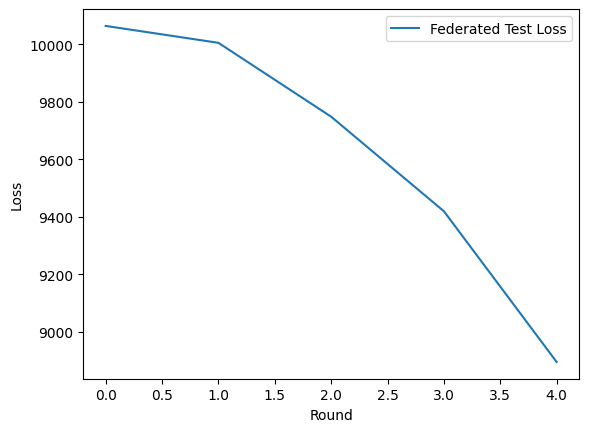